
## Taller de Procesamiento de Señales - TP5 SVM
### Alumno: Julián Stejman

--- 


In [19]:
from seaborn import load_dataset
import pandas as pd

geyser_ds = load_dataset("geyser")
geyser_ds_labels = []
for kind in geyser_ds["kind"]:
    if kind == "long":
        geyser_ds_labels.append(1)
    elif kind == "short":
        geyser_ds_labels.append(-1)  
geyser_ds_labels = pd.DataFrame(geyser_ds_labels)
geyser_ds_labels.shape


(272, 1)

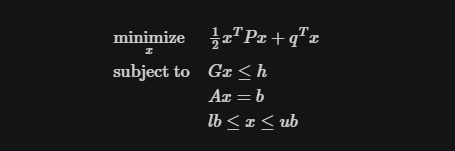

In [ ]:
from qpsolvers import solve_qp
import numpy as np

class SVM:
    def __init__(self, C=1e-8, problem= "primal"):
        self.C = C 
        self.problem = problem
        self._fitted = False
        self._w = None
        self._b = None

    def _fit_primal(self, X, y):
        n_samples, n_features = X.shape
        # Se crean las matrices para el problema primal
        P = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
        P[:n_features, :n_features] = np.eye(n_features) # esto corresponde a los w
        P[n_features, n_features] = 0 # esto corresponde al bias
        P[n_features + 1:, n_features + 1:] = np.eye(n_samples) * self.C # esto corresponde a los slack variables
        
        q = np.zeros(n_features + 1 + n_samples) 
        q[n_features+1:] = 1 # esto hace que la función objetivo sea minimizar la suma de los slack variables
        G = np.zeros((n_samples, n_features + 1 + n_samples))
        h = np.ones(n_samples) * -1

        for i in range(n_samples):
            # los términos son negativos para que se cumpla que -yXw - b <= -1
            # yXw + b >= 1
            G[i, :n_features] = -y[i] * X[i] # términos w
            G[i, n_features] = -y[i] # término b
            G[i, n_features + 1 + i] = -1 # slack variable
        # Se agrega la restricción de que los slack variables son mayores o iguales a 0
        #ξ_i >= 0
        #-ξ_i <= 0
        G_slack = np.zeros((n_samples, n_features + 1 + n_samples))
        G_slack[:, n_features + 1:] = -np.eye(n_samples)
        h_slack = np.zeros(n_samples)
        
        G = np.vstack((G, G_slack))
        h = np.hstack((h, h_slack))
        sol = solve_qp(P, q, G, h)
        self._w = sol[:n_features]
        self._b = sol[n_features]
    # se usa fi(x) = x para el problema dual
    def _fit_dual(self,X, y): 
        n_samples, n_features = X.shape
        K = X @ X.T  
        P = np.outer(y, y) * K  # Kernel trick: K[i, j] = y[i] * y[j] * X[i] @ X[j]
        q = -np.ones(n_samples)
        G = np.zeros((n_samples, n_samples))
        h = np.zeros(n_samples)
        A = y.reshape(1, -1)
        b = np.zeros(1)
        # Se agrega la restricción de que los slack variables son mayores o iguales a 0 
        #α_i >= 0
        #-α_i <= 0
        G_slack = np.zeros((n_samples, n_samples))
        G_slack[:, :] = -np.eye(n_samples)
        h_slack = np.zeros(n_samples)
        G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
        h = np.hstack((h, self.C * np.ones(n_samples)))
        sol = solve_qp(P, q, G, h, A, b)
        self._w = np.zeros(n_features)
        for i in range(n_samples):
            self._w += sol[i] * y[i] * X[i]
        support_vector_indices = (sol > 1e-5) & (sol < 2e-5)  # Consider a small threshold to identify support vectors
        if np.any(support_vector_indices):
            self._b = np.mean(y[support_vector_indices] - X[support_vector_indices] @ self._w)
        else: 
            self._b = 0
        
    def fit(self, X, y):
        self._fitted = True
        if self.problem == "primal":
            return self._fit_primal(X, y)
        elif self.problem == "dual":
            return self._fit_dual(X, y)

    def predict(self, X):
        if not self._fitted:
            raise Exception("Model not fitted yet.")
        
        return np.sign(X @ self._w + self._b)